In [1]:
import math

import torch
import torch.nn as nn
import torch.nn.functional as F

import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.gridspec as gridspec
import scipy.io
from scipy.interpolate import griddata

!pip install pyDOE
from pyDOE import lhs

from collections import OrderedDict
from tqdm import tqdm

sns.set_style("white")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
# Multi-layer Perceptron (Deep Neural Network)
class DNN(torch.nn.Module):
    def __init__(self, layers):
        super(DNN, self).__init__()
        
        self.depth = len(layers) - 1
        self.activation = torch.nn.Tanh
        
        layer_list = list()
        for i in range(self.depth - 1): 
            layer_list.append(('layer_%d' % i, torch.nn.Linear(layers[i], layers[i+1])))
            layer_list.append(('activation_%d' % i, self.activation()))
            
        layer_list.append(('layer_%d' % (self.depth - 1), torch.nn.Linear(layers[-2], layers[-1])))
        layerDict = OrderedDict(layer_list)
        
        self.layers = torch.nn.Sequential(layerDict)
        
    def forward(self, x):
        out = self.layers(x)
        return out

In [3]:
# Physics Informed Neural Network
class PINN():
    def __init__(self, X_y, y, X_f, layers, lb, ub):
        device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

        # boundary conditions
        self.lb = torch.tensor(lb).float().to(device)
        self.ub = torch.tensor(ub).float().to(device)
        
        # data
        self.x_y = torch.tensor(X_y[:, 0:1], requires_grad=True).float().to(device)
        self.t_y = torch.tensor(X_y[:, 1:2], requires_grad=True).float().to(device)
        self.x_f = torch.tensor(X_f[:, 0:1], requires_grad=True).float().to(device)
        self.t_f = torch.tensor(X_f[:, 1:2], requires_grad=True).float().to(device)
        self.y = torch.tensor(y).float().to(device)
        
        # deep neural networks
        self.layers = layers
        self.dnn = DNN(layers).to(device)
        
        # optimizers: using the same settings
        self.optimizer = torch.optim.LBFGS(
            self.dnn.parameters(), 
            lr=1.0, 
            max_iter=50000, 
            max_eval=50000, 
            history_size=50,
            tolerance_grad=1e-5, 
            tolerance_change=1.0 * np.finfo(float).eps,
            line_search_fn="strong_wolfe"      
        )
        self.iter = 0

    def net_y(self, x, t):  
        y = self.dnn(torch.cat([x, t], dim=1))
        return y
    
    def net_f(self, x, t):
        y = self.net_y(x, t)
        
        dy_dt = torch.autograd.grad(inputs=t, outputs=y, grad_outputs=torch.ones_like(y), retain_graph=True, create_graph=True)[0]
        dy_dx = torch.autograd.grad(inputs=x, outputs=y, grad_outputs=torch.ones_like(y), retain_graph=True, create_graph=True)[0]
        dy_dxx = torch.autograd.grad(inputs=x, outputs=dy_dx, grad_outputs=torch.ones_like(dy_dx), retain_graph=True, create_graph=True)[0]
        
        f = dy_dt - dy_dxx + (torch.exp(-t))*(torch.sin(math.pi * x) - (math.pi)*(math.pi)*torch.sin(math.pi * x))
        return f

    def loss_func(self):
        self.optimizer.zero_grad()
        
        y_pred = self.net_y(self.x_y, self.t_y)
        f_pred = self.net_f(self.x_f, self.t_f)
        # print("y:", type(self.y))
        # print("f_pred:", type(f_pred))
        # print("y_pred:", type(y_pred))
        loss_y = torch.mean((self.y - y_pred) ** 2)
        loss_f = torch.mean(f_pred ** 2)
        
        loss = loss_y + loss_f
        
        loss.backward()
        self.iter += 1
        if self.iter % 100 == 0:
            print('Iter %d, Loss: %.5e, Loss_u: %.5e, Loss_f: %.5e' % (self.iter, loss.item(), loss_y.item(), loss_f.item()))
        return loss
    
    def train(self):
        self.dnn.train()
        self.optimizer.step(self.loss_func)
     
    def predict(self, X):
        device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
        
        x = torch.tensor(X[:, 0:1], requires_grad=True).float().to(device)
        t = torch.tensor(X[:, 1:2], requires_grad=True).float().to(device)

        self.dnn.eval()
        y = self.net_y(x, t)
        f = self.net_f(x, t)
        y = y.detach().cpu().numpy()
        f = f.detach().cpu().numpy()
        return y, f

In [4]:
N_u = 500
N_f = 60000
layers = [2, 20, 20, 20, 20, 20, 20, 20, 20, 1]

h = 0.01
k = 0.01
x = torch.arange(-1, 1, h)
t = torch.arange(0, 1, k)

# print("x:", x.shape)
# print("t:", t.shape)

X, T = np.meshgrid(x,t)
X = torch.from_numpy(X)
T = torch.from_numpy(T)

# print("X:", X.shape)
# print("T:", T.shape)

Exact = torch.ones_like(X)
Exact = (torch.exp(-T))*(torch.sin(math.pi * X))

# print(Exact.shape)
# print(Exact)
# sns.heatmap(Exact, cmap='jet')

X_test = np.hstack((X.flatten()[:,None], T.flatten()[:,None]))
y_test = Exact.flatten()[:,None]              

# print("X_train:", X_test.shape)
# print("y_train:", y_test.shape)

# Domain bounds
lb = X_test.min(0)
ub = X_test.max(0)    

x1 = np.hstack((X[0:1,:].T, T[0:1,:].T))
y1 = Exact[0:1,:].T
x2 = np.hstack((X[:,0:1], T[:,0:1]))
y2 = Exact[:,0:1]
x3 = np.hstack((X[-1:,:].T, T[-1:,:].T))
y3 = Exact[-1:,:].T
x4 = np.hstack((X[:,-1:], T[:,-1:]))
y4 = Exact[:,-1:]

X_y_train = np.vstack([x1, x2, x3, x4])
X_f_train = lb + (ub-lb)*lhs(2, N_f)
X_f_train = np.vstack((X_f_train, X_y_train))
y_train   = np.vstack([y1, y2, y3, y4])

idx = np.random.choice(X_y_train.shape[0], N_u, replace=False)
X_y_train = X_y_train[idx, :]
y_train = y_train[idx,:]

In [5]:
model = PINN(X_y_train, y_train, X_f_train, layers, lb, ub)
model.train()

Iter 100, Loss: 3.77465e-02, Loss_u: 1.15565e-02, Loss_f: 2.61899e-02
Iter 200, Loss: 6.09224e-03, Loss_u: 2.30768e-03, Loss_f: 3.78456e-03
Iter 300, Loss: 1.86460e-03, Loss_u: 6.06939e-04, Loss_f: 1.25766e-03
Iter 400, Loss: 8.68201e-04, Loss_u: 4.42816e-05, Loss_f: 8.23920e-04
Iter 500, Loss: 4.80628e-04, Loss_u: 6.05953e-05, Loss_f: 4.20033e-04
Iter 600, Loss: 3.21300e-04, Loss_u: 6.18185e-05, Loss_f: 2.59482e-04
Iter 700, Loss: 2.40926e-04, Loss_u: 4.96017e-05, Loss_f: 1.91324e-04
Iter 800, Loss: 1.87749e-04, Loss_u: 1.83687e-05, Loss_f: 1.69380e-04
Iter 900, Loss: 1.55444e-04, Loss_u: 2.19415e-05, Loss_f: 1.33503e-04
Iter 1000, Loss: 9.05122e-05, Loss_u: 8.00297e-06, Loss_f: 8.25092e-05
Iter 1100, Loss: 7.62179e-05, Loss_u: 7.56553e-06, Loss_f: 6.86524e-05
Iter 1200, Loss: 6.62132e-05, Loss_u: 5.41753e-06, Loss_f: 6.07957e-05
Iter 1300, Loss: 5.70659e-05, Loss_u: 4.64340e-06, Loss_f: 5.24225e-05
Iter 1400, Loss: 5.10064e-05, Loss_u: 4.34687e-06, Loss_f: 4.66595e-05
Iter 1500, Loss

In [6]:
y_pred, f_pred = model.predict(X_test)

# Relative L2 Error
error_y = np.linalg.norm(y_test-y_pred,2)/np.linalg.norm(y_test,2)
print('Relative L2 Error y: %e' % (error_y))                     

# Absolute error
Y_pred = griddata(X_test, y_pred.flatten(), (X, T), method='cubic')
Error = np.abs(Exact - Y_pred)

Relative L2 Error y: 3.054207e-03


## Visualizations

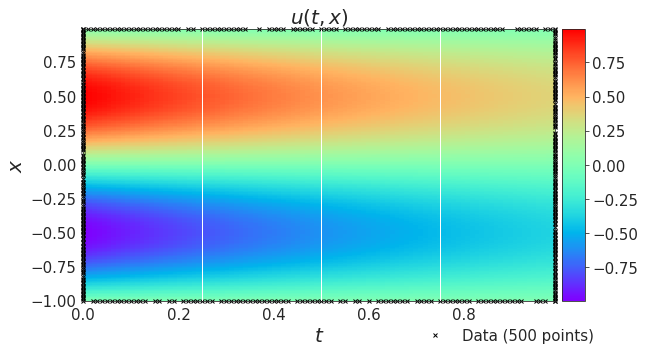

In [7]:
####### Row 0: u(t,x) ##################    

fig = plt.figure(figsize=(9, 5))
ax = fig.add_subplot(111)

h = ax.imshow(Y_pred.T, interpolation='nearest', cmap='rainbow', 
              extent=[t.min(), t.max(), x.min(), x.max()], 
              origin='lower', aspect='auto')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.10)
cbar = fig.colorbar(h, cax=cax)
cbar.ax.tick_params(labelsize=15) 

ax.plot(
    X_y_train[:,1], 
    X_y_train[:,0], 
    'kx', label = 'Data (%d points)' % (y_train.shape[0]), 
    markersize = 4,  # marker size doubled
    clip_on = False,
    alpha=1.0
)

line = np.linspace(x.min(), x.max(), 2)[:,None]
ax.plot(t[25]*np.ones((2,1)), line, 'w-', linewidth = 1)
ax.plot(t[50]*np.ones((2,1)), line, 'w-', linewidth = 1)
ax.plot(t[75]*np.ones((2,1)), line, 'w-', linewidth = 1)

ax.set_xlabel('$t$', size=20)
ax.set_ylabel('$x$', size=20)
ax.legend(
    loc='upper center', 
    bbox_to_anchor=(0.9, -0.05), 
    ncol=5, 
    frameon=False, 
    prop={'size': 15}
)
ax.set_title('$u(t,x)$', fontsize = 20) 
ax.tick_params(labelsize=15)

plt.show()

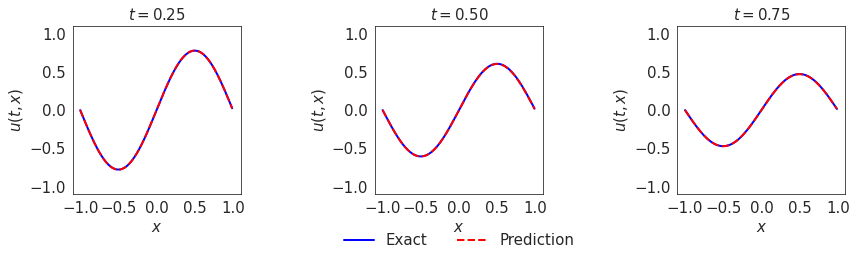

In [8]:
####### Row 1: u(t,x) slices ################## 

fig = plt.figure(figsize=(14, 10))
ax = fig.add_subplot(111)

gs1 = gridspec.GridSpec(1, 3)
gs1.update(top=1-1.0/3.0-0.1, bottom=1.0-2.0/3.0, left=0.1, right=0.9, wspace=0.5)

ax = plt.subplot(gs1[0, 0])
ax.plot(x,Exact[25,:], 'b-', linewidth = 2, label = 'Exact')       
ax.plot(x,Y_pred[25,:], 'r--', linewidth = 2, label = 'Prediction')
ax.set_xlabel('$x$')
ax.set_ylabel('$u(t,x)$')    
ax.set_title('$t = 0.25$', fontsize = 15)
ax.axis('square')
ax.set_xlim([-1.1,1.1])
ax.set_ylim([-1.1,1.1])

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(15)

ax = plt.subplot(gs1[0, 1])
ax.plot(x,Exact[50,:], 'b-', linewidth = 2, label = 'Exact')       
ax.plot(x,Y_pred[50,:], 'r--', linewidth = 2, label = 'Prediction')
ax.set_xlabel('$x$')
ax.set_ylabel('$u(t,x)$')
ax.axis('square')
ax.set_xlim([-1.1,1.1])
ax.set_ylim([-1.1,1.1])
ax.set_title('$t = 0.50$', fontsize = 15)
ax.legend(
    loc='upper center', 
    bbox_to_anchor=(0.5, -0.15), 
    ncol=5, 
    frameon=False, 
    prop={'size': 15}
)

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(15)

ax = plt.subplot(gs1[0, 2])
ax.plot(x,Exact[75,:], 'b-', linewidth = 2, label = 'Exact')       
ax.plot(x,Y_pred[75,:], 'r--', linewidth = 2, label = 'Prediction')
ax.set_xlabel('$x$')
ax.set_ylabel('$u(t,x)$')
ax.axis('square')
ax.set_xlim([-1.1,1.1])
ax.set_ylim([-1.1,1.1])    
ax.set_title('$t = 0.75$', fontsize = 15)

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(15)

plt.show()